In [1]:
from dotenv import load_dotenv
from datetime import datetime, timedelta
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import time
import requests
import random
import pytz

load_dotenv('.env')

True

In [2]:
report_time = pd.to_datetime('10:30:00')

# Load Data
1. Data from https://www.backtestmarket.com/en/wti-pack
1. The timezone of the date time in the data is GMT-6

In [3]:
df_wti = pd.read_csv(
    './data/backtestmarket/cl-15m.csv',
    sep=';', header=0,
    names=['date', 'time', 'open', 'high', 'low', 'close', 'volume']
)

df_wti['date'] = pd.to_datetime(df_wti['date'], format='%d/%m/%Y')
df_wti['date'] = df_wti['date'].dt.strftime('%m-%d-%Y')

df_wti['datetime'] = pd.to_datetime(df_wti['date'] + ' ' + df_wti['time'])

# convert to new york timezone
df_wti['datetime'] = df_wti['datetime'].dt.tz_localize('Etc/GMT+6')
ny_tz = pytz.timezone('America/New_York')
df_wti['datetime'] = df_wti['datetime'].dt.tz_convert(ny_tz)
df_wti['datetime'] = pd.to_datetime(df_wti['datetime'])

# df_wti['month'] = df_wti['datetime'].dt.month
# df_wti['day'] = df_wti['datetime'].dt.day
# df_wti['year'] = df_wti['datetime'].dt.year

df_wti.head()

,date,time,open,high,low,close,volume,datetime
0,04-01-2007,17:30:00,65.73,65.85,65.60,65.70,288,2007-04-01 19:30:00-04:00
1,04-01-2007,17:45:00,65.70,65.75,65.62,65.67,53,2007-04-01 19:45:00-04:00
2,04-01-2007,18:00:00,65.71,65.75,65.54,65.63,111,2007-04-01 20:00:00-04:00
3,04-01-2007,18:15:00,65.65,65.65,65.55,65.60,91,2007-04-01 20:15:00-04:00
4,04-01-2007,18:30:00,65.58,65.61,65.53,65.56,153,2007-04-01 20:30:00-04:00


## Check data
Double check if data is good
1. If there's missing timeframe
1. Check prices during covid (use daily to check maybe)
1. Compare to Yahoo Finance

### Check for missing day

In [4]:
# years = df_wti['date'].dt.year.unique().tolist()
missing = {}
for year, df_year in df_wti.groupby(df_wti['datetime'].dt.year):
    start_date = pd.to_datetime(f'{year}-01-01')
    end_date = pd.to_datetime(f'{year}-12-31')
    date_range = pd.date_range(start=start_date, end=end_date)
    missing_dates = date_range[~date_range.isin(df_year['date'])].tolist()
    missing[year] = missing_dates

    print(f'{year}: {len(missing_dates)}')
    print(missing_dates[:5])
    print()

2007: 130
[Timestamp('2007-01-01 00:00:00'), Timestamp('2007-01-02 00:00:00'), Timestamp('2007-01-03 00:00:00'), Timestamp('2007-01-04 00:00:00'), Timestamp('2007-01-05 00:00:00')]

2008: 53
[Timestamp('2008-01-05 00:00:00'), Timestamp('2008-01-12 00:00:00'), Timestamp('2008-01-19 00:00:00'), Timestamp('2008-01-26 00:00:00'), Timestamp('2008-02-02 00:00:00')]

2009: 55
[Timestamp('2009-01-03 00:00:00'), Timestamp('2009-01-10 00:00:00'), Timestamp('2009-01-17 00:00:00'), Timestamp('2009-01-24 00:00:00'), Timestamp('2009-01-31 00:00:00')]

2010: 55
[Timestamp('2010-01-01 00:00:00'), Timestamp('2010-01-02 00:00:00'), Timestamp('2010-01-09 00:00:00'), Timestamp('2010-01-16 00:00:00'), Timestamp('2010-01-23 00:00:00')]

2011: 55
[Timestamp('2011-01-01 00:00:00'), Timestamp('2011-01-08 00:00:00'), Timestamp('2011-01-15 00:00:00'), Timestamp('2011-01-22 00:00:00'), Timestamp('2011-01-29 00:00:00')]

2012: 54
[Timestamp('2012-01-01 00:00:00'), Timestamp('2012-01-07 00:00:00'), Timestamp('2012-

In [5]:
# make sure every day has data between 9 and 12

grouped_day = df_wti.groupby(pd.Grouper(key='datetime', freq='D'))

day_with_no_data = []
for day, df_day in grouped_day:
    df_range = df_day[(df_day['datetime'].dt.hour >= 7) & (df_day['datetime'].dt.hour < 15)]
    if df_range.shape[0] != 32 and day.strftime('%A') not in ['Saturday', 'Sunday']:
        day_with_no_data.append(
            f'{day.strftime("%Y-%m-%d")}\t\t{day.strftime("%A")}\t\tNo data: {df_range.shape[0] == 0}'
        )

- For year 2007, the data starts from April
- Saturday has no data
- Sunday data range 1800 - 2345
- Most business day in the dataset has data for 0700 - 1500, there are only 172 business days where data is not "complete"

### Covid Period
1. April 2020 should have negative values?
1. However, the prices of crude oil hit a low at $6 in this data.
1. It is likely that this data is not "near month futures'.  
1. The high of this data is at July 2008 at $ 147. https://tradingeconomics.com/commodity/crude-oil

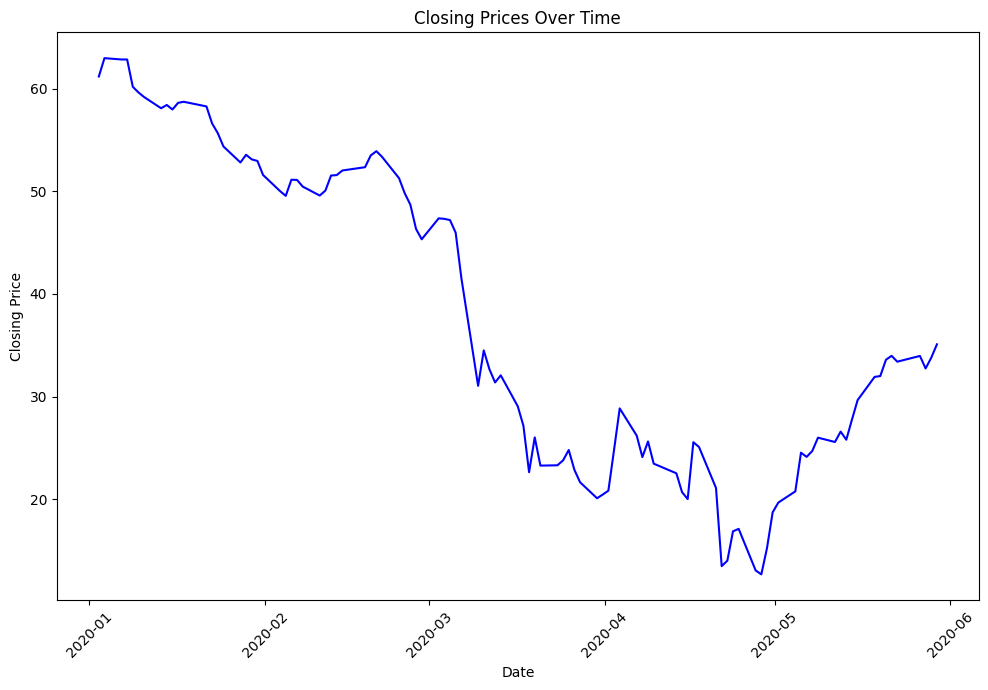

In [6]:
df_covid = df_wti[
    (df_wti['datetime'] > pd.Timestamp('2020-01-01', tz='America/New_York')) & \
        (df_wti['datetime'] < pd.Timestamp('2020-06-01', tz='America/New_York'))
    ]

# plot daily at 4pm
df_4pm = df_covid[(df_covid['datetime'].dt.hour == 16) & (df_covid['datetime'].dt.minute == 0)]

plt.figure(figsize=(10, 7))
plt.plot(df_4pm['datetime'], df_4pm['close'], linestyle='-', color='blue')

# Set plot title and labels
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [15]:
df_wti[df_wti['high'] == df_wti['high'].max()]

,date,time,open,high,low,close,volume,datetime
30588,07-11-2008,08:30:00,147.08,147.27,146.27,146.71,11311,2008-07-11 10:30:00-04:00


In [71]:
df_wti[df_wti['low'] == df_wti['low'].min()]

,date,time,open,high,low,close,volume,datetime
309756,04-21-2020,12:45:00,10.44,10.53,6.5,9.45,89573,2020-04-21 14:45:00-04:00


### Compare to Yahoo Finance

In [16]:
df_yf = pd.read_csv('./data/yfin_20231201_1328_cl.csv')
df_yf['Datetime'] = pd.to_datetime(df_yf['Datetime'])
df_yf['Datetime'] = df_yf['Datetime'].dt.tz_localize('America/New_York')
df_yf.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2023-10-02 13:15:00-04:00,89.180000,89.260002,89.050003,89.089996,89.089996,0
1,2023-10-02 13:30:00-04:00,89.089996,89.139999,88.989998,89.000000,89.000000,4110
2,2023-10-02 13:45:00-04:00,89.010002,89.129997,88.930000,88.949997,88.949997,5010
3,2023-10-02 14:00:00-04:00,88.949997,89.000000,88.720001,88.769997,88.769997,9262
4,2023-10-02 14:15:00-04:00,88.779999,88.919998,88.730003,88.809998,88.809998,17869


In [17]:
df_yf_nov = df_yf[df_yf['Datetime'].dt.month == 11]
df_wti_nov = df_wti[(df_wti['datetime'].dt.month == 11) & (df_wti['datetime'].dt.year == 2023)]

print(f'Yahoo Finance: {df_yf_nov.shape[0]}')
print(f'Backtest market: {df_wti_nov.shape[0]}')

Yahoo Finance: 1883
Backtest market: 1825


In [18]:
only_in_yf_nov = df_yf_nov[~df_yf_nov['Datetime'].isin(df_wti_nov['datetime'])]
only_in_wti_nov = df_wti_nov[~df_wti_nov['datetime'].isin(df_yf_nov['Datetime'])]

In [19]:
for day in range(1, 31):
    yf_sub = df_yf_nov[df_yf_nov['Datetime'].dt.day == day]
    wti_sub = df_wti_nov[df_wti_nov['datetime'].dt.day == day]

    if yf_sub.shape[0] != wti_sub.shape[0]:
        print(f'{day}: YF:{yf_sub.shape[0]}  BM: {wti_sub.shape[0]}')
    
    if yf_sub.shape[0] == 0:
        print(f'{day}: yf no data')

    if wti_sub.shape[0] == 0:
        print(f'{day}: BM no data')

3: YF:68  BM: 72
4: yf no data
4: BM no data
11: yf no data
11: BM no data
18: yf no data
18: BM no data
19: YF:19  BM: 24
20: YF:44  BM: 92
21: YF:78  BM: 92
24: YF:14  BM: 55
25: yf no data
25: BM no data
29: YF:92  BM: 4
30: YF:82  BM: 0
30: BM no data


In [20]:
day_yf = df_yf_nov[df_yf_nov['Datetime'].dt.day == 29]
day_wti = df_wti_nov[df_wti_nov['datetime'].dt.day == 29]

Generate November 2023 closing price plot the compare
- The sections that don't match are due to missing data from either source

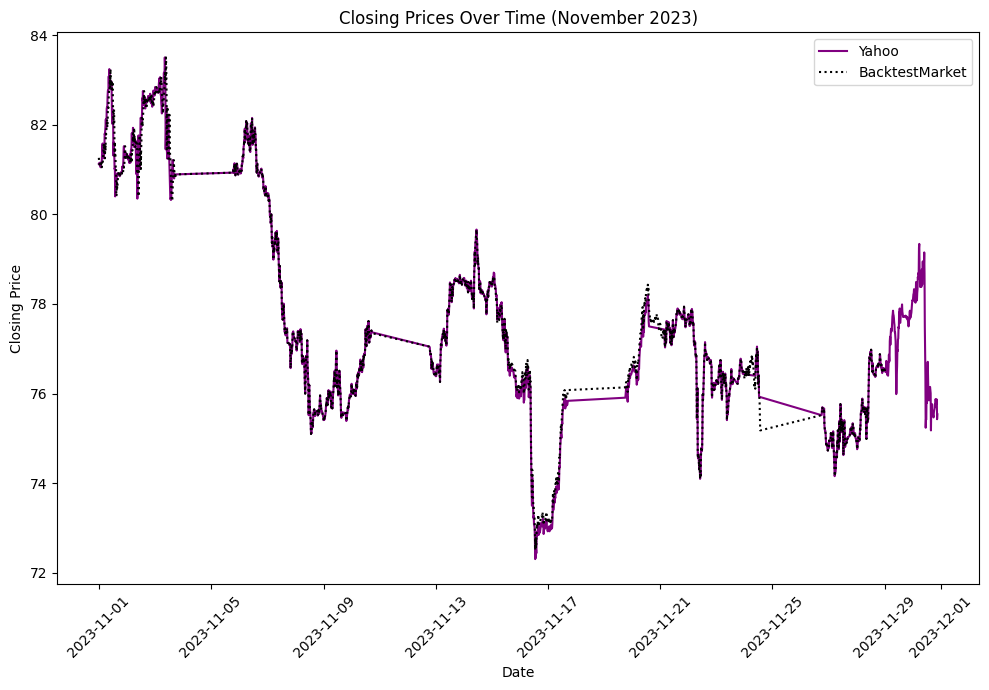

In [21]:
df_yf_month = df_yf[df_yf['Datetime'].dt.month == 11]
df_wti_month = df_wti[(df_wti['datetime'].dt.month == 11) & (df_wti['datetime'].dt.year == 2023)]

plt.figure(figsize=(10, 7))
plt.plot(df_yf_month['Datetime'], df_yf_month['Close'], linestyle='solid', color='purple', label='Yahoo')
plt.plot(df_wti_month['datetime'], df_wti_month['close'], linestyle='dotted', color='black', label='BacktestMarket')

# Set plot title and labels
plt.title('Closing Prices Over Time (November 2023)')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show plot
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
df_yf_oct = df_yf[df_yf['Datetime'].dt.month == 10]
df_wti_oct = df_wti[(df_wti['datetime'].dt.month == 10) & (df_wti['datetime'].dt.year == 2023)]

for day in range(1, 31):
    yf_sub = df_yf_oct[df_yf_oct['Datetime'].dt.day == day]
    wti_sub = df_wti_oct[df_wti_oct['datetime'].dt.day == day]

    if yf_sub.shape[0] != wti_sub.shape[0]:
        print(f'{day}: YF:{yf_sub.shape[0]}  BM: {wti_sub.shape[0]}')
    
    if yf_sub.shape[0] == 0:
        print(f'{day}: yf no data')

    if wti_sub.shape[0] == 0:
        print(f'{day}: BM no data')

1: YF:0  BM: 20
1: yf no data
2: YF:39  BM: 92
6: YF:68  BM: 72
7: yf no data
7: BM no data
8: YF:24  BM: 20
13: YF:68  BM: 72
14: yf no data
14: BM no data
15: YF:24  BM: 20
18: YF:88  BM: 92
19: YF:81  BM: 92
20: YF:38  BM: 72
21: yf no data
21: BM no data
22: YF:24  BM: 20
27: YF:68  BM: 72
28: yf no data
28: BM no data
29: YF:24  BM: 20


In [26]:
df_oct = pd.merge(df_wti_oct, df_yf_oct, how='left', left_on='datetime', right_on='Datetime')
df_oct.head()

,date,time,open,high,low,close,volume,datetime,Datetime,Open,High,Low,Close,Adj Close,Volume
0,10-01-2023,17:00:00,90.82,91.13,90.82,91.02,910,2023-10-01 19:00:00-04:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,10-01-2023,17:15:00,91.02,91.24,91.02,91.09,708,2023-10-01 19:15:00-04:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,10-01-2023,17:30:00,91.09,91.11,91.06,91.07,217,2023-10-01 19:30:00-04:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,10-01-2023,17:45:00,91.07,91.16,91.06,91.16,176,2023-10-01 19:45:00-04:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,10-01-2023,18:00:00,91.14,91.19,91.10,91.15,167,2023-10-01 20:00:00-04:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN


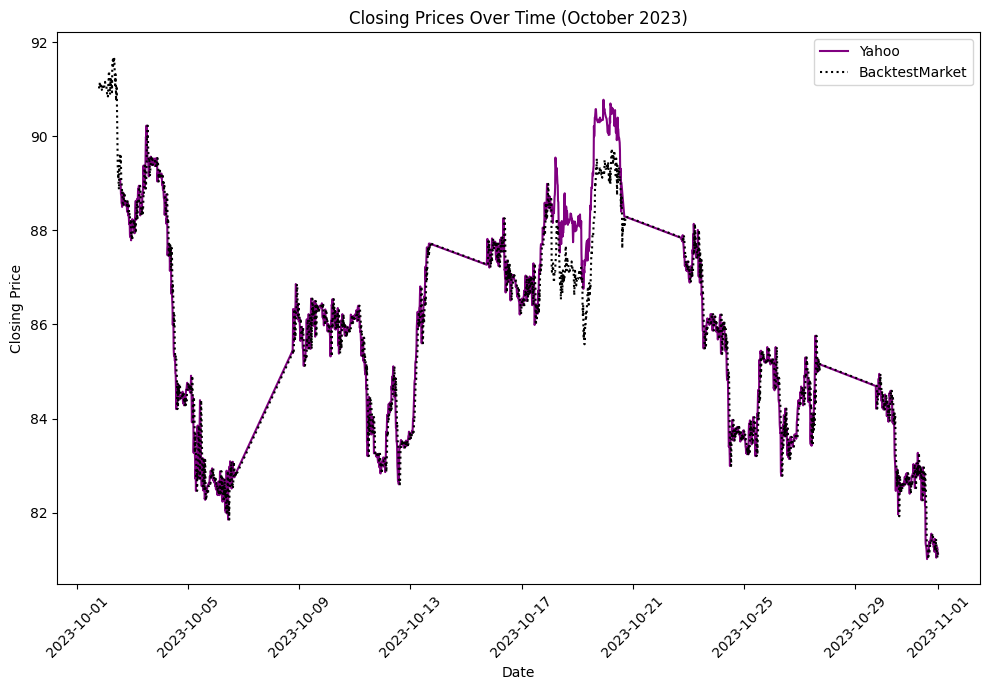

In [22]:
df_yf_month = df_yf[df_yf['Datetime'].dt.month == 10]
df_wti_month = df_wti[(df_wti['datetime'].dt.month == 10) & (df_wti['datetime'].dt.year == 2023)]

plt.figure(figsize=(10, 7))
plt.plot(df_yf_month['Datetime'], df_yf_month['Close'], linestyle='solid', color='purple', label='Yahoo')
plt.plot(df_wti_month['datetime'], df_wti_month['close'], linestyle='dotted', color='black', label='BacktestMarket')

# Set plot title and labels
plt.title('Closing Prices Over Time (October 2023)')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show plot
plt.legend()
plt.tight_layout()
plt.show()

# Volume plot 2023  

- For crude oil, each contract expires on the third business day prior to the 25th calendar day of the month preceding the delivery month. If the 25th calendar day of the month is a non-business day, trading ceases on the third business day prior to the business day preceding the 25th calendar day.  
https://www.eia.gov/dnav/pet/TblDefs/pet_pri_fut_tbldef2.asp  

- Electronic trading of crude oil futures is conducted from 6:00 p.m. U.S. until 5:00 p.m. U.S. ET, Sunday through Friday. Crude oil futures contracts trade every calendar month, from January through December.

Notes:
- Exclude Sundays from data due to low trading activity

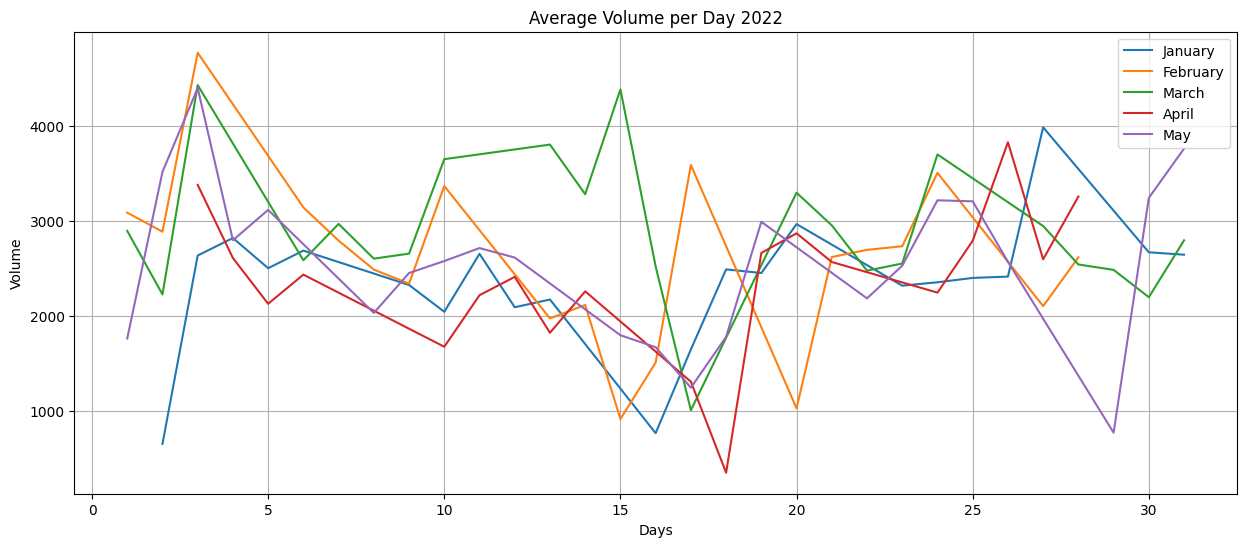

In [72]:
start_date = '2023-01-01'
end_date = '2023-10-31'
filtered_data = df_wti[(df_wti['datetime'] >= start_date) & (df_wti['datetime'] <= end_date) & ~(df_wti['datetime'].dt.day_name() == 'Sunday')]

# Group the data by month
grouped = filtered_data.groupby(filtered_data['datetime'].dt.month)

plt.figure(figsize=(15, 6))

for month, df_month in grouped:
    if month <= 5:
        volume = df_month.groupby(df_month['datetime'].dt.date)['volume'].mean().reset_index()
        volume['day'] = pd.to_datetime(volume['datetime']).dt.day
        plt.plot(volume['day'], volume['volume'], label=df_month['datetime'].dt.month_name().iloc[0])

plt.xlabel('Days')
plt.ylabel('Volume')
plt.title('Average Volume per Day 2022')
plt.legend()
plt.grid(True)
plt.show()

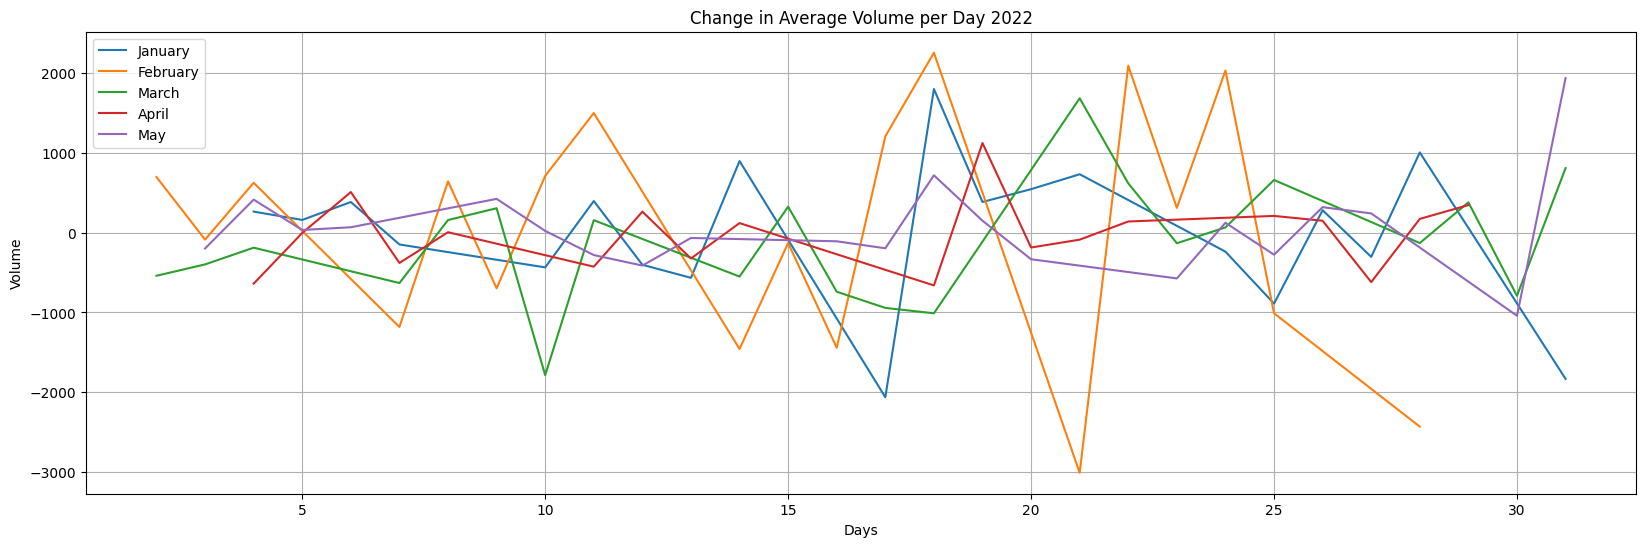

In [30]:
start_date = '2022-01-01'
end_date = '2022-10-31'
filtered_data = df_wti[(df_wti['datetime'] >= start_date) & (df_wti['datetime'] <= end_date) & ~(df_wti['datetime'].dt.day_name() == 'Sunday')]

# Group the data by month
grouped = filtered_data.groupby(filtered_data['datetime'].dt.month)

plt.figure(figsize=(20, 6))

for month, df_month in grouped:
    if month <= 5:
        volume = df_month.groupby(df_month['datetime'].dt.date)['volume'].mean().reset_index()
        volume['day'] = pd.to_datetime(volume['datetime']).dt.day
        volume['diff'] = volume['volume'].diff()
        plt.plot(volume['day'], volume['diff'], label=df_month['datetime'].dt.month_name().iloc[0])

plt.xlabel('Days')
plt.ylabel('Volume')
plt.title('Change in Average Volume per Day 2022')
plt.legend()
plt.grid(True)
plt.show()

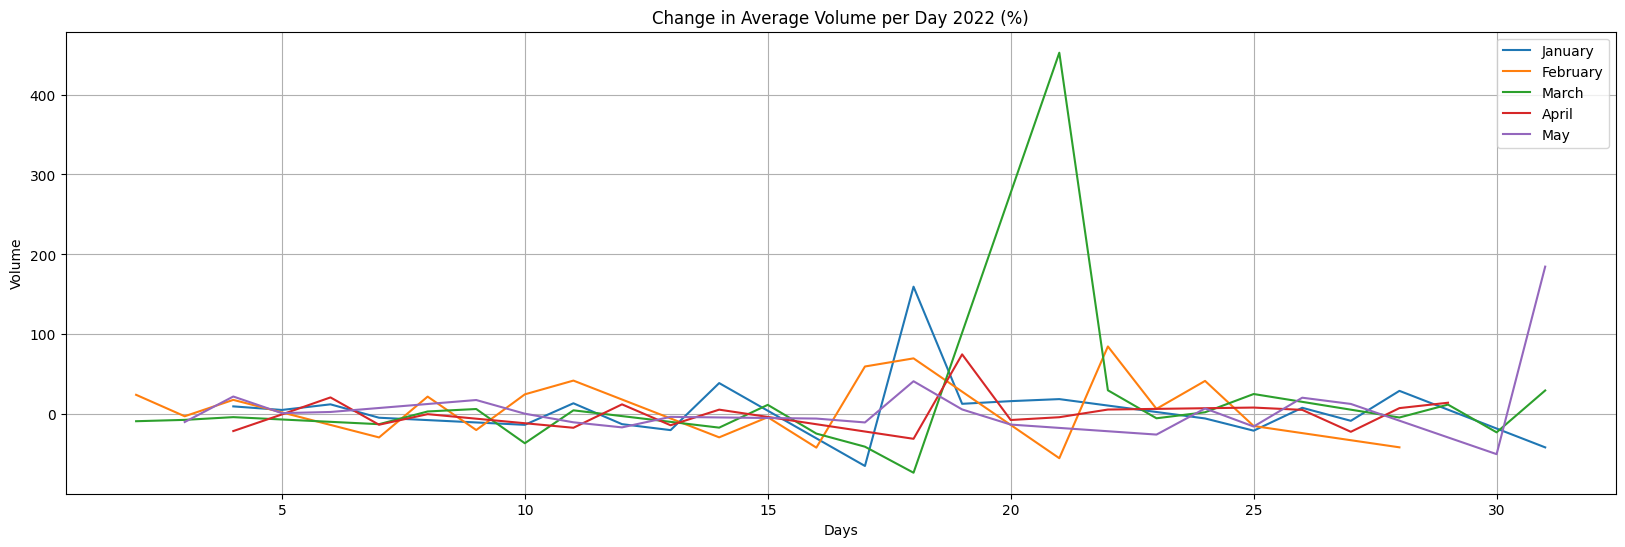

In [36]:
start_date = '2022-01-01'
end_date = '2022-10-31'
filtered_data = df_wti[(df_wti['datetime'] >= start_date) & (df_wti['datetime'] <= end_date) & ~(df_wti['datetime'].dt.day_name() == 'Sunday')]

# Group the data by month
grouped = filtered_data.groupby(filtered_data['datetime'].dt.month)

plt.figure(figsize=(20, 6))

for month, df_month in grouped:
    if month <= 5:
        volume = df_month.groupby(df_month['datetime'].dt.date)['volume'].mean().reset_index()
        volume['day'] = pd.to_datetime(volume['datetime']).dt.day
        volume['diff'] = volume['volume'].pct_change() * 100
        # if month == 3:
        #     display(volume)
        #     test = volume
        plt.plot(volume['day'], volume['diff'], label=df_month['datetime'].dt.month_name().iloc[0])

plt.xlabel('Days')
plt.ylabel('Volume')
plt.title('Change in Average Volume per Day 2022 (%)')
plt.legend()
plt.grid(True)
plt.show()

The spike is due to the increase in volume on the 21st of March 2022  
Russia - Ukraine war? https://en.wikipedia.org/wiki/Portal:Current_events/March_2022  

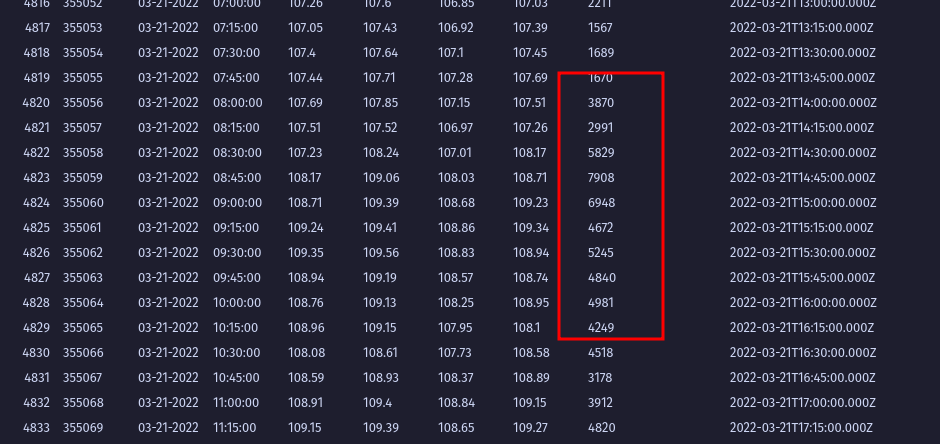

Volume plot on random days  
- Volume cluster around 0900 - 1500

/tmp/ipykernel_15930/4033494017.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_dates = random.sample(set(random_dates), 4)


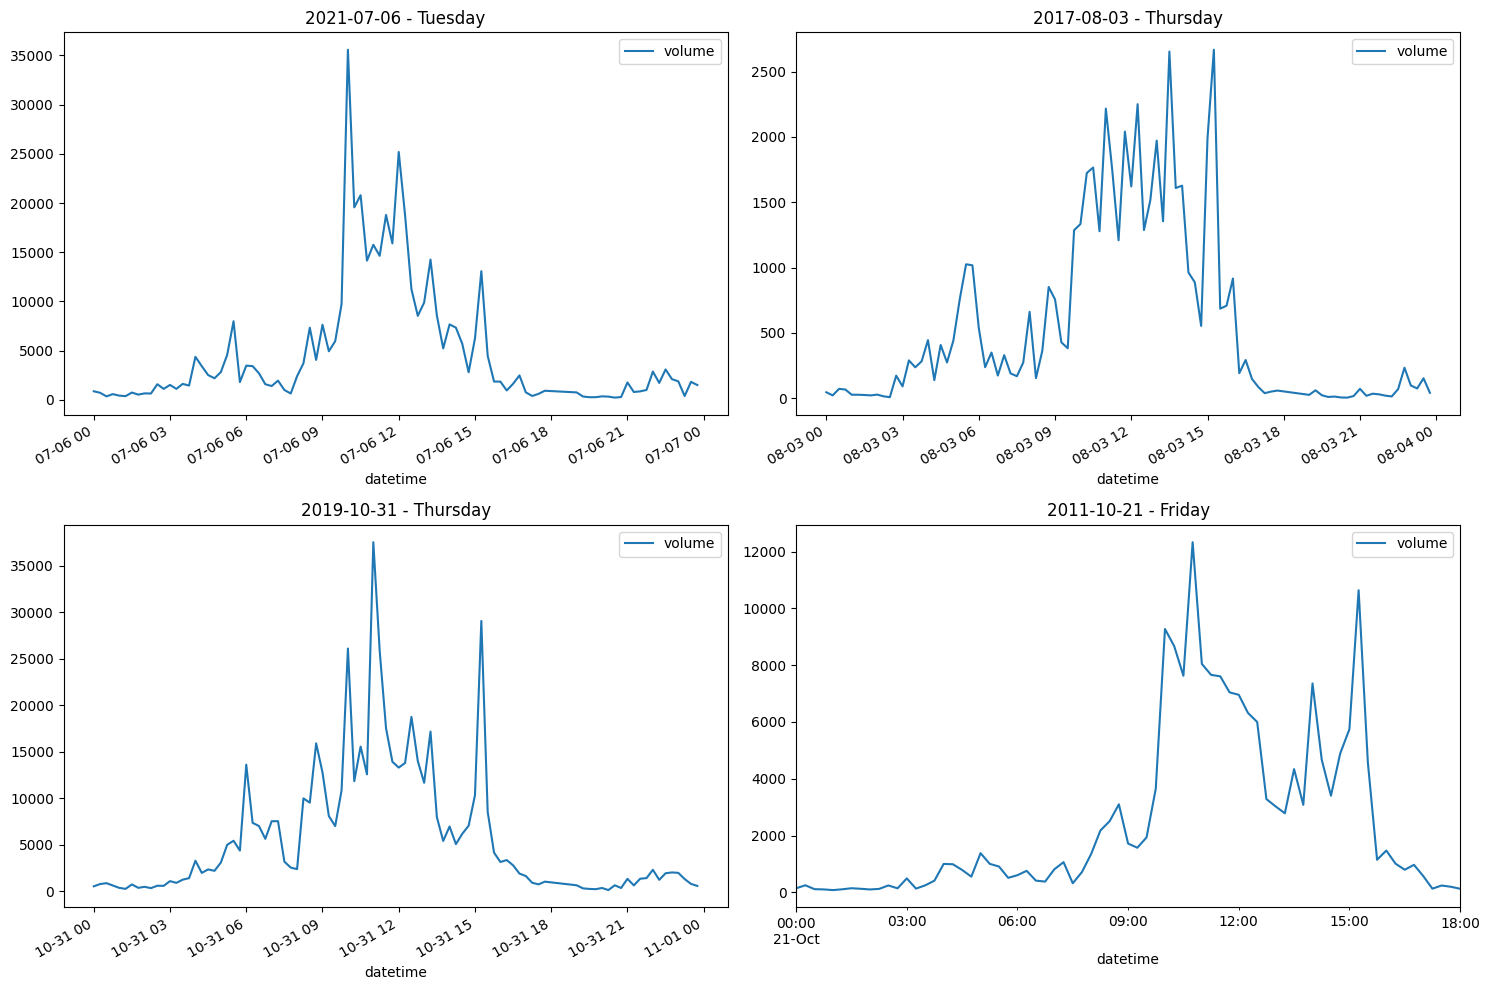

In [39]:
df_tmp = df_wti[df_wti['datetime'].dt.dayofweek != 6]
random_dates = df_tmp['datetime'].dt.date.unique()
selected_dates = random.sample(set(random_dates), 4)

# Filter dataframe for the selected 4 days
selected_data = df_wti[df_wti['datetime'].dt.date.isin(selected_dates)]

# Create a 2x2 subplot layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for i, date in enumerate(selected_dates):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    data_for_plot = selected_data[selected_data['datetime'].dt.date == date]
    data_for_plot.plot(x='datetime', y='volume', ax=ax, title=f'{str(date)} - {date.strftime("%A")}')

# Adjust layout
plt.tight_layout()
plt.show()

# Wednesdays

/tmp/ipykernel_15930/2325026905.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_dates = random.sample(set(random_dates), 4)


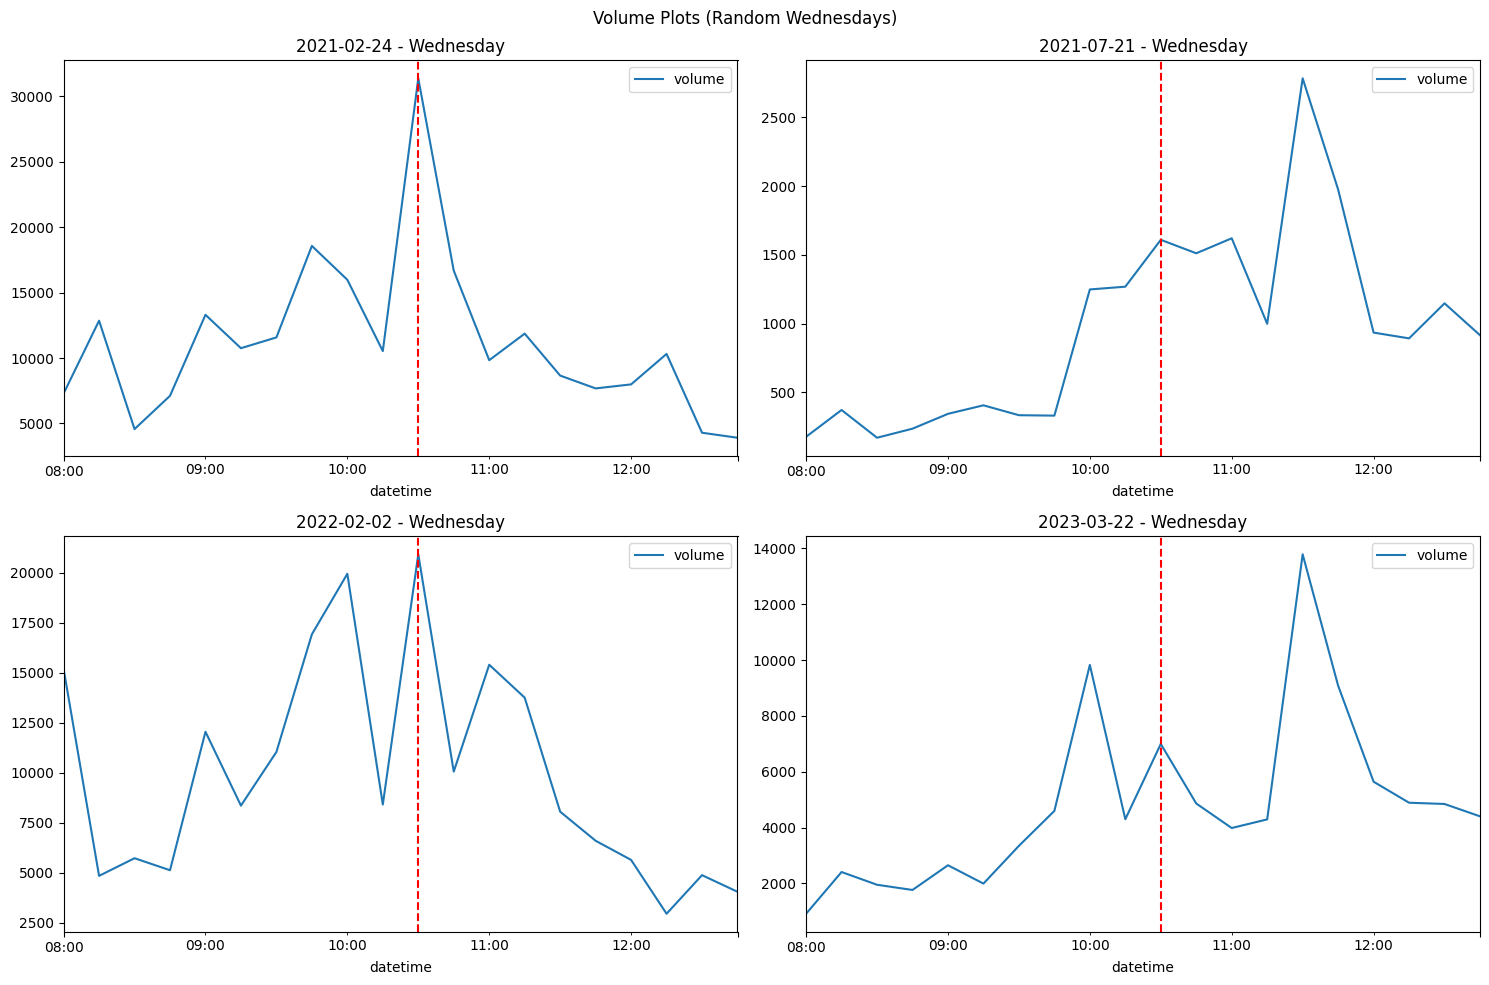

In [74]:
df_tmp = df_wti[(df_wti['datetime'].dt.dayofweek == 2) & (df_wti['datetime'].dt.year >= 2021)]
random_dates = df_tmp['datetime'].dt.date.unique()
selected_dates = random.sample(set(random_dates), 4)

# Filter dataframe for the selected 4 days
selected_data = df_wti[df_wti['datetime'].dt.date.isin(selected_dates)]

vertical_line_time = datetime.strptime("10:30", "%H:%M").time()

# Create a 2x2 subplot layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for i, date in enumerate(selected_dates):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    data_for_plot = selected_data[selected_data['datetime'].dt.date == date]
    data_for_plot = data_for_plot[(data_for_plot['datetime'].dt.hour >= 8) & (data_for_plot['datetime'].dt.hour <= 12)]
    data_for_plot['diff'] = data_for_plot['volume'].pct_change() * 100
    data_for_plot.plot(x='datetime', y='volume', ax=ax, title=f'{str(date)} - {date.strftime("%A")}')

    ax.axvline(x=datetime.combine(date, vertical_line_time), color='red', linestyle='--', label='10:30 AM')

# Adjust layout
plt.suptitle('Volume Plots (Random Wednesdays)')
plt.tight_layout()
plt.show()

In [43]:
print(df_tmp.head().to_markdown())

|        | date       | time     |   open |   high |   low |   close |   volume | datetime                  |
|-------:|:-----------|:---------|-------:|-------:|------:|--------:|---------:|:--------------------------|
| 326546 | 01-05-2021 | 23:00:00 |  50.04 |  50.1  | 50.01 |   50.03 |      596 | 2021-01-06 00:00:00-05:00 |
| 326547 | 01-05-2021 | 23:15:00 |  50.03 |  50.1  | 50    |   50.01 |      562 | 2021-01-06 00:15:00-05:00 |
| 326548 | 01-05-2021 | 23:30:00 |  50.01 |  50.1  | 49.99 |   50.08 |      704 | 2021-01-06 00:30:00-05:00 |
| 326549 | 01-05-2021 | 23:45:00 |  50.08 |  50.09 | 49.97 |   50.02 |     1074 | 2021-01-06 00:45:00-05:00 |
| 326550 | 01-06-2021 | 00:00:00 |  50.02 |  50.06 | 49.94 |   50    |     1319 | 2021-01-06 01:00:00-05:00 |


How to test the impact / correlation of the EIA report if it is released every Wednesday? 

/tmp/ipykernel_15930/1863423929.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_dates = random.sample(set(random_dates), 4)


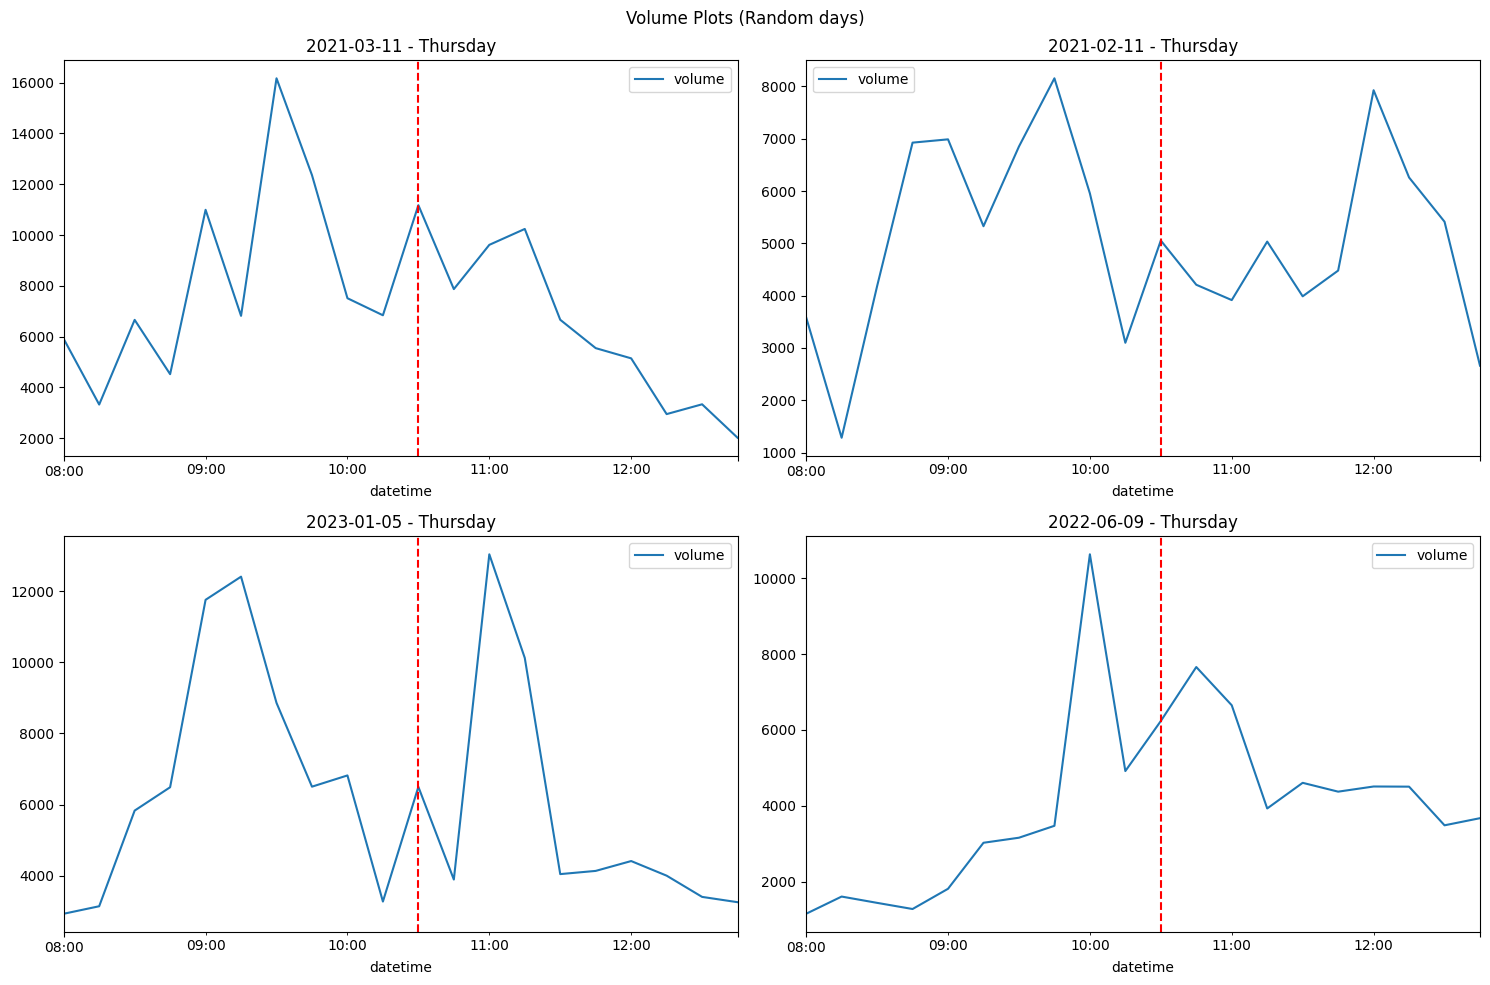

In [75]:
df_tmp = df_wti[(df_wti['datetime'].dt.dayofweek == 3) & (df_wti['datetime'].dt.year >= 2021)]
random_dates = df_tmp['datetime'].dt.date.unique()
selected_dates = random.sample(set(random_dates), 4)

# Filter dataframe for the selected 4 days
selected_data = df_wti[df_wti['datetime'].dt.date.isin(selected_dates)]

vertical_line_time = datetime.strptime("10:30", "%H:%M").time()

# Create a 2x2 subplot layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for i, date in enumerate(selected_dates):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    data_for_plot = selected_data[selected_data['datetime'].dt.date == date]
    data_for_plot = data_for_plot[(data_for_plot['datetime'].dt.hour >= 8) & (data_for_plot['datetime'].dt.hour <= 12)]
    data_for_plot['diff'] = data_for_plot['volume'].pct_change() * 100
    data_for_plot.plot(x='datetime', y='volume', ax=ax, title=f'{str(date)} - {date.strftime("%A")}')

    ax.axvline(x=datetime.combine(date, vertical_line_time), color='red', linestyle='--', label='10:30 AM')

# Adjust layout
plt.suptitle('Volume Plots (Random days)')
plt.tight_layout()
plt.show()

In [54]:
df_wednesday = df_wti[(df_wti['datetime'].dt.dayofweek == 2) & (df_wti['datetime'].dt.year >= 2021)]

for day, df_tmp in df_wednesday.groupby(pd.Grouper(key='datetime', freq='D')):
    df_tmp = df_tmp[(df_tmp['datetime'].dt.hour >= 8) & (df_tmp['datetime'].dt.hour < 13)]
    two_hours_before = df_tmp[(df_tmp['datetime'].dt.time >= (report_time - pd.Timedelta(hours=2)).time()) & (df_tmp['datetime'].dt.time < (report_time).time())]
    two_hours_after = df_tmp[(df_tmp['datetime'].dt.time >= (report_time).time()) & (df_tmp['datetime'].dt.time < (report_time + pd.Timedelta(hours=2)).time())]

    # Calculate correlation between prices before and after the report
    correlation = two_hours_before['volume'].corr(two_hours_after['volume'])

    # Display the correlation coefficient
    print(f'{day.date()}: {correlation}')
    break

2021-01-06: nan


/tmp/ipykernel_15930/3118244114.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_dates = random.sample(set(random_dates), 1)


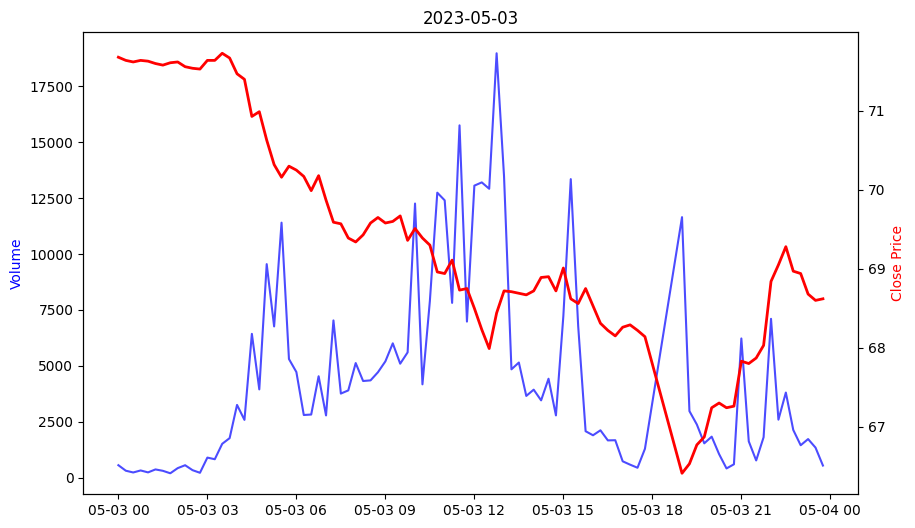

In [78]:
random_dates = df_wednesday['datetime'].dt.date.unique()
selected_dates = random.sample(set(random_dates), 1)

df_tmp = df_wti[df_wti['datetime'].dt.date.isin(selected_dates)]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot histogram (volume) on the left y-axis
ax1.plot(df_tmp['datetime'], df_tmp['volume'], alpha=0.7, color='blue')
ax1.set_ylabel('Volume', color='blue')

# Create a second y-axis for the line chart (close price)
ax2 = ax1.twinx()
ax2.plot(df_tmp['datetime'], df_tmp['close'], color='red', linestyle='-', linewidth=2)
ax2.set_ylabel('Close Price', color='red')

# Set common x-axis label and title
plt.xlabel('Time')
plt.title(f'{selected_dates[0]}')

# Show plot
plt.show()